In [1]:
import urllib
from KalshiClientsBase import ExchangeClient
import pandas as pd
import numpy as np
from datetime import datetime
import json
import urllib.request,urllib.parse,urllib.error
import matplotlib.pyplot as plt
import openpyxl

In [2]:
username = "" # change this 
password = "" # change this (for extra security, we recommend using a config file)
exchange_api_base = "https://trading-api.kalshi.com"

exchange_client = ExchangeClient(exchange_api_base, username, password)
print(exchange_client.user_id)
exchange_client.get_market_url('HOME-0001')

3301c8c8-6275-4727-b424-373bbb58f39e


'/v1/markets/HOME-0001'

In [39]:
markets = exchange_client.get_public_markets()
markets_df = pd.DataFrame(markets['markets']).set_index('id')
corecpis = markets_df[markets_df.title.str.contains("core")]

In [33]:
def get_contracts(markets_df,year, month):
    #get range of contracts of different rates for the CPI month
    #used to check unique ID of each contract. markets_df contains all contracts
    #e.g. year = 22, month = 'NOV'
    ranged_ticker = f'CPICORE-{str(year)}{month}'
    target_contracts = markets_df[markets_df.ranged_group_ticker.str.contains(ranged_ticker)]
    columns = ['ranged_group_ticker','name','volume','yes_bid','yes_ask','list_date','close_date']
    targets = target_contracts[columns]
    return targets

all_july_corecpis = get_contracts(markets_df,22,'NOV')

In [34]:
all_july_corecpis

,ranged_group_ticker,name,volume,yes_bid,yes_ask,list_date,close_date
id,,,,,,,
9d66e231-6e7a-4fc5-8d23-828d14abf0ff,CPICORE-22NOV,0.0%,15046,94,97,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
3510d881-e669-416b-8d44-2ff5dfd166c2,CPICORE-22NOV,0.1%,61458,88,90,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
7dc5058e-03ee-4ce9-9c84-dbfbf202d0d7,CPICORE-22NOV,0.2%,20236,61,66,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
c39720e9-73a5-4f3d-b9e7-10de231501ed,CPICORE-22NOV,0.3%,16264,38,42,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
796313f3-6059-497e-8c6a-abd0e4c04aee,CPICORE-22NOV,0.4%,5640,20,22,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
1c4a4b8e-15a6-43d0-8e57-7a075e0f2ef9,CPICORE-22NOV,0.5%,4990,7,10,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
65442197-cd2e-4abb-87dc-f89dde05f4ca,CPICORE-22NOV,0.6%,5700,1,4,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
5268f6d3-e9c8-4435-b208-7794363aa980,CPICORE-22NOV,0.7%,982,1,3,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z
04ecd0e3-0a26-4a0e-acd8-75fdcc59eb32,CPICORE-22NOV,0.8%,1428,1,2,2022-07-01T14:00:00Z,2022-12-13T13:25:00Z


In [6]:
from tqdm.notebook import tqdm

In [7]:
all_df = []
for i in tqdm(range(all_july_corecpis.shape[0])):
    market_id = all_july_corecpis.index[i]
    url = f'https://trading-api.kalshi.com/v1/cached/markets/{market_id}/stats_history'
    uh = urllib.request.urlopen(url)
    data= uh.read().decode()
    js = json.loads(data)

    df = pd.DataFrame(js['market_stats_points'])
    df['ts']= df['ts'].apply(lambda x: datetime.fromtimestamp(x))
    df = df.drop('price',axis = 1)
    df['ranged_group_ticker'] = all_july_corecpis.ranged_group_ticker[i]
    df['name'] = all_july_corecpis.name[i]
    all_df += [df]

In [8]:
df_all = pd.concat(all_df)
df_all = df_all.reset_index(drop=True)
#yes_ask is price I can sell at (trader can buy at); yes_bid is price i can buy at
#volume is total comulative trade volume
def add_feats(df):
    #adding some features that measures change & spread
    df = df.loc[df['volume'] > 0].copy()
    df['ask_change'] = df['yes_ask'].diff(1)
    df['bid_change'] = df['yes_bid'].diff(1)
    df['volume_change'] = df['volume'].diff(1)
    df['bid_ask_spread'] = df['yes_ask'] - df['yes_bid']
    df['bid_ask_spread_change'] = df['bid_ask_spread'].diff(1)
    return df

df_all_transformed = add_feats(df_all)
df_all_transformed = df_all_transformed.sort_values(by=['ranged_group_ticker', 'name','ts']).reset_index(drop=True)

In [30]:
df_all_transformed.shape[0]/9

290.44444444444446

In [ ]:
#t = 1.. T signal = 1, buy hold to expiryt
#(PT - Pt) * signal
#signal * (Pt + 1 -Pt)

In [354]:
#df_all_transformed = df_all_transformed.reset_index(drop=True)
# return from now until holding to expiry 1.. T, 2... T 

# no pnl assuming hold to maturity - target, (target 3: target/time) (using No contracts)
target = df_all_transformed.groupby(['ranged_group_ticker', 'name']).apply(lambda x: x['yes_ask'].iloc[-2] - x['yes_bid'])
df_all_transformed['target'] = target.reset_index().sort_values(by='level_2')['yes_bid'].rename({"yes_bid":"target"}, axis = 1)
df_all_transformed['target'] = target.reset_index().sort_values(by='level_2')['yes_bid'].rename({"yes_bid":"target"}, axis = 1)

target = df_all_transformed.groupby(['ranged_group_ticker', 'name']).apply(lambda x: x['ts'].iloc[-1] -  x['ts'])
df_all_transformed['ttm'] = target.reset_index().sort_values(by='level_2')['ts'].rename({"ts":"ttm"}, axis = 1)
df_all_transformed['target2'] = df_all_transformed['target'] / (df_all_transformed['ttm'].dt.days + 1)

# yes pnl
target = df_all_transformed.groupby(['ranged_group_ticker', 'name']).apply(lambda x: x['yes_bid'].iloc[-2] - x['yes_ask'].rename({"yes_ask":"target3"}, axis = 1) )

df_all_transformed['target3'] = target.reset_index().sort_values(by='level_2')['yes_ask']
df_all_transformed['target3'] = target.reset_index().sort_values(by='level_2')['yes_ask'].rename({"yes_ask":"target3"}, axis = 1)

df_all_transformed['target4'] = df_all_transformed['target3'] / (df_all_transformed['ttm'].dt.days + 1)


In [355]:
# sort by date for train test split
df_all_transformed = df_all_transformed.sort_values(by=['ts', 'ranged_group_ticker', 'name']).reset_index(drop=True)

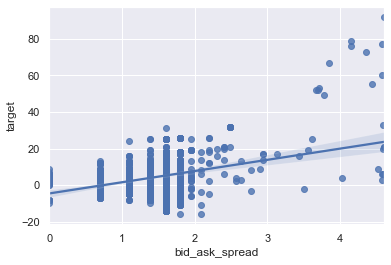

In [356]:
import seaborn as sns
sns.set()
sns.regplot(np.log(df_all_transformed['bid_ask_spread']), df_all_transformed['target'])

In [357]:
df_all_transformed = df_all_transformed.set_index(['ts', 'ranged_group_ticker', 'name'])

In [358]:
from sklearn.model_selection import train_test_split

In [395]:
#target 2(buying Nos) PnL 
X_train, X_test, y_train, y_test = train_test_split(df_all_transformed['bid_ask_spread'], 
                                                    df_all_transformed['target'], 
                                                    test_size=0.1,shuffle = False)


In [396]:
#check see dates of trading is < dates of test
assert X_test.reset_index()['ts'].min() > X_train.reset_index()['ts'].max()

In [397]:
from statsmodels.regression.linear_model import OLS
from statsmodels.discrete.discrete_model import Logit
res = Logit(y_train > 0, X_train).fit()
y_pred = res.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.624793
         Iterations 6


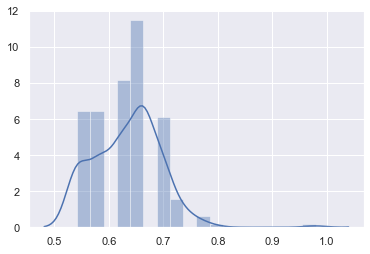

In [398]:
sns.distplot(y_pred)

In [399]:
y_test.index = X_test.index

In [400]:
yhat= res.predict()
k = 0.65
pnl = ((yhat * (yhat > k)) * y_train) # use signal as position if greater than threshold
pnl_out = (y_pred * (y_pred>k)   * y_test)

pnl = (((yhat > k)) * y_train) # use signal as position if greater than threshold
pnl_out = ((y_pred>k)   * y_test)

In [401]:
#in vs out avg pnl
y_test.mean(), y_train.mean()

(2.6412213740458017, 3.9715136054421767)

In [402]:
no_days = (pnl.reset_index()['ts'].max() - pnl.reset_index()['ts'].min()).days
pnl.mean() / (1e-9 + pnl.std()) * np.sqrt(250 / no_days)

0.5621898854231853

In [403]:
no_days = (pnl_out.reset_index()['ts'].max() - pnl_out.reset_index()['ts'].min()).days
pnl_out.mean() / (1e-9 + pnl_out.std()) * np.sqrt(250 / no_days)

4.74813032226776

In [412]:
#flip -- -shows signals may flip and there would be transaction cost
((y_pred > 0.75) * 1).reset_index().query("name == '0.4%'")

,ts,ranged_group_ticker,name,0
0,2022-10-09 02:57:08,CPICORE-22SEP,0.4%,0
5,2022-10-09 13:15:34,CPICORE-22SEP,0.4%,0
15,2022-10-09 17:29:15,CPICORE-22SEP,0.4%,0
24,2022-10-09 23:40:08,CPICORE-22SEP,0.4%,0
32,2022-10-10 01:04:40,CPICORE-22SEP,0.4%,0
39,2022-10-10 02:47:13,CPICORE-22SEP,0.4%,0
45,2022-10-10 04:57:18,CPICORE-22SEP,0.4%,0
54,2022-10-10 13:17:17,CPICORE-22SEP,0.4%,0
64,2022-10-10 15:07:40,CPICORE-22SEP,0.4%,0
70,2022-10-10 18:02:44,CPICORE-22SEP,0.4%,0


In [406]:
#pure way: when go in , everything afterwards one; if signal says i exit, i will sell. 

ts                   ranged_group_ticker  name
2022-07-03 18:42:50  CPICORE-22SEP        0.3%    21
2022-07-03 23:38:44  CPICORE-22SEP        0.7%     0
2022-07-03 23:38:56  CPICORE-22SEP        0.5%    19
2022-07-03 23:39:06  CPICORE-22SEP        0.3%    21
2022-07-03 23:39:14  CPICORE-22SEP        0.2%    17
                                                  ..
2022-10-08 23:56:30  CPICORE-22SEP        0.2%     5
2022-10-09 02:46:49  CPICORE-22SEP        0.5%     0
2022-10-09 02:48:07  CPICORE-22SEP        0.1%     0
2022-10-09 02:55:47  CPICORE-22SEP        0.3%     7
2022-10-09 02:56:43  CPICORE-22SEP        0.8%     3
Name: target, Length: 2352, dtype: int64

In [368]:
pnl_out.groupby(['ranged_group_ticker', 'name']).apply(lambda x: x.mean() / (1e-9 + x.std()) * np.sqrt(250))

ranged_group_ticker  name
CPICORE-22SEP        0.0%     0.000000
                     0.1%     4.446085
                     0.2%    10.236176
                     0.3%    11.775621
                     0.4%    12.350025
                     0.5%     7.592387
                     0.6%     9.230716
                     0.7%     5.283547
                     0.8%    15.239012
dtype: float64